In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Audi.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_100 Serisi,Seri_200 Serisi,Seri_80 Serisi,...,Model_S3 2.0 TFSI Quattro,Model_S5 3.0 TFSI Quattro,Model_S7 4.0 TFSI Quattro,Model_S8 4.0 TFSI Quattro,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,839000,2015,110,1598,118000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1650000,2017,190,1968,250000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1235000,2020,150,1498,51500,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,785000,2015,110,1598,191000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,835000,2015,150,1968,218000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14704\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,344687.785329,1.618736e+11,402335.191189,141740.264936


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:04:54,202] A new study created in memory with name: no-name-7328c72a-9b88-4add-ae33-ec18ae720ebf
[I 2023-10-08 14:04:54,546] Trial 1 finished with value: 1026086.5057695365 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.13917685719585532, 'max_depth': 13, 'min_child_weight': 123}. Best is trial 1 with value: 1026086.5057695365.
[I 2023-10-08 14:04:54,594] Trial 0 finished with value: 586485.5156366727 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.32961123734876563, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:54,594] Trial 4 finished with value: 1315338.9284393168 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.038093488971584565, 'max_depth': 4, 'min_child_weight': 198}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:54,598] Trial 5 finished with value: 1606364.5169850865 and parameters: {'co

[I 2023-10-08 14:04:56,515] Trial 29 finished with value: 841869.0285649772 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.14412556144599248, 'max_depth': 7, 'min_child_weight': 63}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:56,524] Trial 31 finished with value: 875209.7570117234 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.14423143384559062, 'max_depth': 5, 'min_child_weight': 73}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:56,622] Trial 32 finished with value: 829684.8860374145 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.15536643610143214, 'max_depth': 5, 'min_child_weight': 62}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:56,846] Trial 34 finished with value: 924584.718421599 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.11928503827803533, 'max_depth': 7, 'min_child_weight': 64}. 

[I 2023-10-08 14:04:59,508] Trial 60 finished with value: 701703.5965603798 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4659368339826985, 'max_depth': 10, 'min_child_weight': 44}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:59,515] Trial 64 finished with value: 842898.0373542903 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.48225686155798575, 'max_depth': 4, 'min_child_weight': 119}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:59,515] Trial 61 finished with value: 1384018.5838213728 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02511962586899115, 'max_depth': 8, 'min_child_weight': 46}. Best is trial 0 with value: 586485.5156366727.
[I 2023-10-08 14:04:59,577] Trial 62 finished with value: 656073.25590899 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4877941507317699, 'max_depth': 10, 'min_child_weight': 45}.

[I 2023-10-08 14:05:02,085] Trial 89 finished with value: 637573.7203426204 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.34895233887419236, 'max_depth': 11, 'min_child_weight': 15}. Best is trial 75 with value: 369035.71930687665.
[I 2023-10-08 14:05:02,293] Trial 92 finished with value: 633758.3378494931 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.36286916806582503, 'max_depth': 11, 'min_child_weight': 15}. Best is trial 75 with value: 369035.71930687665.
[I 2023-10-08 14:05:02,314] Trial 91 finished with value: 642961.3463075263 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.3341435231888577, 'max_depth': 11, 'min_child_weight': 16}. Best is trial 75 with value: 369035.71930687665.
[I 2023-10-08 14:05:02,796] Trial 93 finished with value: 679945.8656635622 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.3569343348401959, 'max_depth': 12, 'min_child_weigh

[I 2023-10-08 14:05:05,169] Trial 120 finished with value: 665679.7330696383 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.21981156264174365, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:05,223] Trial 121 finished with value: 408367.4053225746 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.22208999973899227, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:05,288] Trial 122 finished with value: 668518.3060335248 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.22329707408239455, 'max_depth': 8, 'min_child_weight': 21}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:05,367] Trial 123 finished with value: 400543.676619504 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.22561046409712282, 'max_depth': 8, 'min_child_we

[I 2023-10-08 14:05:08,112] Trial 150 finished with value: 385089.9214662188 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4937086257983482, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:08,374] Trial 151 finished with value: 379650.31195584044 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.2539243947269412, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:08,543] Trial 155 finished with value: 353541.34340586484 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.29220508663035966, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:08,617] Trial 154 finished with value: 387373.7049556935 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.2659407166601296, 'max_depth': 6, 'min_child_we

[I 2023-10-08 14:05:11,239] Trial 180 finished with value: 427710.83111697086 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.48028242835215623, 'max_depth': 11, 'min_child_weight': 15}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:11,301] Trial 181 finished with value: 410769.15295813384 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4839207357473269, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:11,334] Trial 182 finished with value: 409371.46210026776 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4990875088885308, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 112 with value: 320195.59225901944.
[I 2023-10-08 14:05:11,370] Trial 183 finished with value: 416166.91195213114 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.35199952690411435, 'max_depth': 11, 'min_

[I 2023-10-08 14:05:14,526] Trial 211 finished with value: 367100.24966513633 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.22440060506075013, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 191 with value: 299766.9923943824.
[I 2023-10-08 14:05:14,685] Trial 210 finished with value: 635500.6655235442 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2202397174106579, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 191 with value: 299766.9923943824.
[I 2023-10-08 14:05:14,856] Trial 212 finished with value: 1206714.158786822 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.04286737237608845, 'max_depth': 12, 'min_child_weight': 17}. Best is trial 191 with value: 299766.9923943824.
[I 2023-10-08 14:05:14,985] Trial 215 finished with value: 634431.1895853858 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.22143200211517952, 'max_depth': 14, 'min_child_

[I 2023-10-08 14:05:18,064] Trial 241 finished with value: 294748.6471204809 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.41058011598423894, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 241 with value: 294748.6471204809.
[I 2023-10-08 14:05:18,190] Trial 240 finished with value: 319622.7002518966 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4005850378679383, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 241 with value: 294748.6471204809.
[I 2023-10-08 14:05:18,240] Trial 242 finished with value: 302192.86118018907 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3088175129111098, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 241 with value: 294748.6471204809.
[I 2023-10-08 14:05:18,309] Trial 243 finished with value: 306747.6467018531 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.30722369854633763, 'max_depth': 12, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 294748.6471
Best params:
	colsample_bytree: 1.0
	subsample: 0.7
	learning_rate: 0.41058011598423894
	max_depth: 12
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 349297.8987438236, 'MSE': 76782796338.4581, 'RMSE': 277097.0882893902, 'MAE': 133151.48876848118}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9435218661875739

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.929532466683344

In [16]:
marka_model = joblib.dump(final_model, "Audi.pkl")

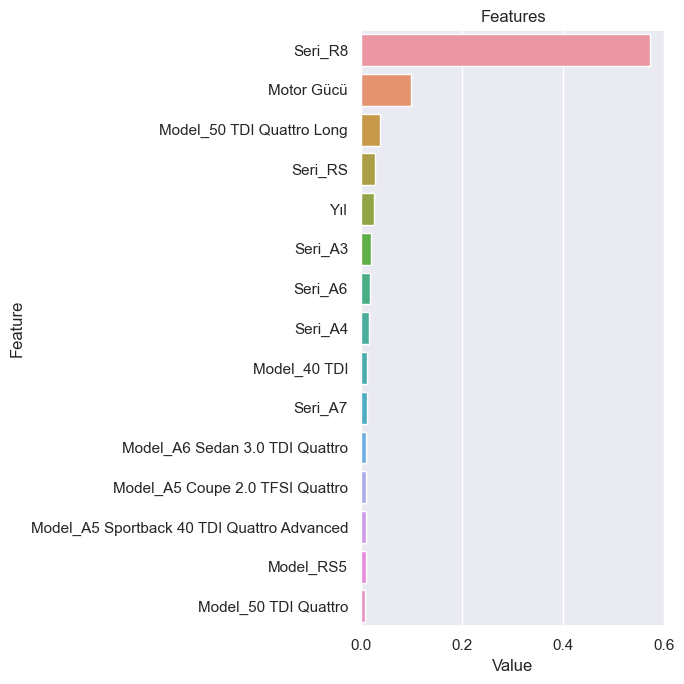

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)

In [18]:
y_test2 = list(y_test)

In [19]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [20]:
df3

,test,pred,fark
0,1150000,1.537799e+06,387798.87500
1,1750000,1.850959e+06,100958.87500
2,880000,7.953524e+05,-84647.62500
3,429000,4.792031e+05,50203.09375
4,2750000,3.051914e+06,301914.00000
...,...,...,...
460,585000,6.227404e+05,37740.37500
461,1250000,1.196974e+06,-53026.00000
462,2925000,2.747184e+06,-177815.75000
463,390000,3.974087e+05,7408.65625


In [21]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,471.0,399862.191083,229039.974623,9.050000e+04,177500.000000,290000.000000,390000.000,465000.000000,559500.00000,754500.00000,4.350000e+06
pred,471.0,386051.937500,130966.945312,1.014875e+05,175274.164062,293813.562500,381125.250,463002.890625,542972.93750,760347.36875,9.096226e+05
fark,471.0,-13810.275743,189582.255273,-3.900788e+06,-77647.359375,-26970.515625,-308.375,21781.187500,42974.09375,98623.87500,2.873716e+05


In [22]:
df3["test"].max()

4350000

In [23]:
df3[df3["test"]==4350000]

,test,pred,fark
428,4350000,449211.78125,-3.900788e+06


In [25]:
df3[df3["test"] > 1000000]

,test,pred,fark
173,1100003,190055.484375,-9.099475e+05
273,1150000,909622.562500,-2.403774e+05
428,4350000,449211.781250,-3.900788e+06


In [33]:
y_train2 = list(y_train)

In [39]:
for i in y_train2:
    if i > 1000000:
        print(i)

1105000
